In [1]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from scipy import stats
import tensorflow as tf
import seaborn as sns
from pylab import rcParams
from sklearn import metrics

from sklearn.model_selection import train_test_split

%matplotlib inline

#sns.set(style='whitegrid', palette='muted', font_scale=1.5)

#rcParams['figure.figsize'] = 14, 8

RANDOM_SEED = 42

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/tensorflow/python/framework/dtypes.py:469: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/tensorflow/python/framework/dtypes.py:470: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/tensorflow/python/framework/dtypes.py:471: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/

In [3]:
columns = ['x-axis', 'y-axis','z-axis','xg-axis', 'yg-axis','zg-axis','activity']
df=pd.read_csv("Act1_noise2.csv",names=columns,skiprows=1)


In [4]:
df

,x-axis,y-axis,z-axis,xg-axis,yg-axis,zg-axis,activity
0,1.0000,2.0000,3.0000,4.0000,5.0000,6.0000,1
1,0.0934,-0.1225,0.7399,37.8049,-152.7439,-26.8902,1
2,0.1689,-0.0379,0.9245,45.0610,-147.9878,-25.7317,1
3,0.2049,0.0226,1.0523,53.5366,-134.3902,-27.1341,1
4,0.2417,0.0170,1.1290,53.2317,-117.6829,-25.9146,1
...,...,...,...,...,...,...,...
61202,-0.7471,-0.2786,0.5436,-7.0732,-9.2683,-17.9878,2
61203,-0.7456,-0.2745,0.5353,-2.3780,-6.2805,-14.5732,2
61204,-0.7316,-0.2733,0.5357,-2.9268,-6.5244,-11.5854,2
61205,-0.7307,-0.2755,0.5414,-2.6220,-7.9268,-9.7561,2


In [5]:
tf.__version__

'1.4.0'

In [6]:
df.shape

(61207, 7)

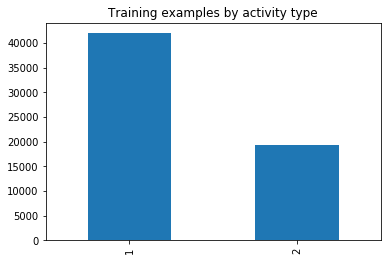

In [7]:
df['activity'].value_counts().plot(kind='bar', title='Training examples by activity type');

In [8]:
N_TIME_STEPS = 500
N_FEATURES = 6
step = 100
segments = []
labels = []
for i in range(0, len(df) - N_TIME_STEPS, step):
    xs = df['x-axis'].values[i: i + N_TIME_STEPS]
    ys = df['y-axis'].values[i: i + N_TIME_STEPS]
    zs = df['z-axis'].values[i: i + N_TIME_STEPS]
    xsg = df['xg-axis'].values[i: i + N_TIME_STEPS]
    ysg = df['yg-axis'].values[i: i + N_TIME_STEPS]
    zsg = df['zg-axis'].values[i: i + N_TIME_STEPS]
    label = stats.mode(df['activity'][i: i + N_TIME_STEPS])[0][0]
    #print label
    segments.append([xs, ys, zs, xsg, ysg, zsg])
    labels.append(label)
    #print labels

In [9]:
reshaped_segments = np.asarray(segments, dtype= np.float32).reshape(-1, N_TIME_STEPS, N_FEATURES)
labels = np.asarray(pd.get_dummies(labels), dtype = np.float32)

In [10]:
reshaped_segments.shape

(608, 500, 6)

In [11]:
X_train, X_test, y_train, y_test = train_test_split(
        reshaped_segments, labels, test_size=0.2, random_state=RANDOM_SEED)

In [12]:
X_train.shape

(486, 500, 6)

In [13]:
X_test.shape

(122, 500, 6)

In [14]:
#y_test

In [15]:
N_CLASSES = 2
N_HIDDEN_UNITS = 64

In [16]:
def create_LSTM_model(inputs):
    W = {
        'hidden': tf.Variable(tf.random_normal([N_FEATURES, N_HIDDEN_UNITS])),
        'output': tf.Variable(tf.random_normal([N_HIDDEN_UNITS, N_CLASSES]))
    }
    biases = {
        'hidden': tf.Variable(tf.random_normal([N_HIDDEN_UNITS], mean=1.0)),
        'output': tf.Variable(tf.random_normal([N_CLASSES]))
    }
    
    X = tf.transpose(inputs, [1, 0, 2])
    X = tf.reshape(X, [-1, N_FEATURES])
    hidden = tf.nn.relu(tf.matmul(X, W['hidden']) + biases['hidden'])
    hidden =tf.split(hidden, N_TIME_STEPS, 0)

    # Stack 2 LSTM layers
    
    lstm_layers = [tf.contrib.rnn.BasicLSTMCell(N_HIDDEN_UNITS, forget_bias=1.0) for _ in range(2)]
    lstm_layers = tf.contrib.rnn.MultiRNNCell(lstm_layers)

    outputs, _ = tf.contrib.rnn.static_rnn(lstm_layers, hidden, dtype=tf.float32)

    # Get output for the last time step
    lstm_last_output = outputs[-1]

    return tf.matmul(lstm_last_output, W['output']) + biases['output']

In [17]:
#tf.reset_default_graph()

X = tf.placeholder(tf.float32, [None, N_TIME_STEPS, N_FEATURES], name="input")
Y = tf.placeholder(tf.float32, [None, N_CLASSES])

In [18]:
pred_Y = create_LSTM_model(X)

pred_softmax = tf.nn.softmax(pred_Y, name="y_")

In [19]:
L2_LOSS = 0.0015

l2 = L2_LOSS * \
    sum(tf.nn.l2_loss(tf_var) for tf_var in tf.trainable_variables())

loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = pred_Y, labels = Y)) + l2

In [20]:
LEARNING_RATE = 0.00025
optimizer = tf.train.AdamOptimizer(learning_rate=LEARNING_RATE).minimize(loss)

correct_pred = tf.equal(tf.argmax(pred_softmax, 1), tf.argmax(Y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, dtype=tf.float32))

In [21]:
N_EPOCHS = 40
BATCH_SIZE = 128

In [22]:
saver = tf.train.Saver()

history = dict(train_loss=[], 
                     train_acc=[], 
                     test_loss=[], 
                     test_acc=[])

sess=tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

train_count = len(X_train)

for i in range(1, N_EPOCHS + 1):
    for start, end in zip(range(0, train_count, BATCH_SIZE),
                          range(BATCH_SIZE, train_count + 1,BATCH_SIZE)):
        sess.run(optimizer, feed_dict={X: X_train[start:end],
                                       Y: y_train[start:end]})

    _, acc_train, loss_train = sess.run([pred_softmax, accuracy, loss], feed_dict={
                                            X: X_train, Y: y_train})

    _, acc_test, loss_test = sess.run([pred_softmax, accuracy, loss], feed_dict={
                                            X: X_test, Y: y_test})

    history['train_loss'].append(loss_train)
    history['train_acc'].append(acc_train)
    history['test_loss'].append(loss_test)
    history['test_acc'].append(acc_test)
    #if i != 1 and i % 10 != 0:
        #continue

    print("epoch " + str(i) + ":  "+ "test accuracy:" + " " + str(acc_test) + " " + "loss:" + str(loss_test))
    
predictions, acc_final, loss_final = sess.run([pred_softmax, accuracy, loss], feed_dict={X: X_test, Y: y_test})

#print()
print("final results: accuracy:   " + str(acc_final) + "\t" +  "loss:  " +str(loss_final))

epoch 1:  test accuracy: 0.647541 loss:1.3357484
epoch 2:  test accuracy: 0.59016395 loss:1.3398645
epoch 3:  test accuracy: 0.6803279 loss:1.3266537
epoch 4:  test accuracy: 0.6803279 loss:1.3299745
epoch 5:  test accuracy: 0.6393443 loss:1.33216
epoch 6:  test accuracy: 0.63114756 loss:1.3349633
epoch 7:  test accuracy: 0.6557377 loss:1.3207588
epoch 8:  test accuracy: 0.6885246 loss:1.3064456
epoch 9:  test accuracy: 0.6885246 loss:1.302553
epoch 10:  test accuracy: 0.704918 loss:1.303987
epoch 11:  test accuracy: 0.71311474 loss:1.3035741
epoch 12:  test accuracy: 0.71311474 loss:1.297853
epoch 13:  test accuracy: 0.71311474 loss:1.2957054
epoch 14:  test accuracy: 0.6967213 loss:1.2975326
epoch 15:  test accuracy: 0.71311474 loss:1.2944665
epoch 16:  test accuracy: 0.71311474 loss:1.2836946
epoch 17:  test accuracy: 0.704918 loss:1.2782068
epoch 18:  test accuracy: 0.6967213 loss:1.2713418
epoch 19:  test accuracy: 0.704918 loss:1.2531841
epoch 20:  test accuracy: 0.72131145 loss:

In [22]:
#predictions

In [23]:
pickle.dump(predictions, open("predictions_act1.p", "wb"))
pickle.dump(history, open("history_act1.p", "wb"))
tf.train.write_graph(sess.graph_def, '.', './checkpoint/activity_1.pbtxt')  
saver.save(sess, save_path = "./checkpoint/activity_1.ckpt")
sess.close()

In [24]:
history = pickle.load(open("history_act1.p", "rb"))
predictions = pickle.load(open("predictions_act1.p", "rb"))

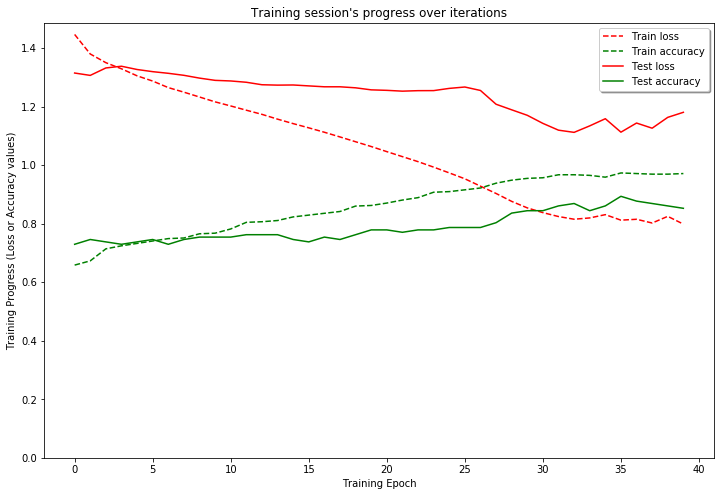

In [25]:
plt.figure(figsize=(12, 8))

plt.plot(np.array(history['train_loss']), "r--", label="Train loss")
plt.plot(np.array(history['train_acc']), "g--", label="Train accuracy")

plt.plot(np.array(history['test_loss']), "r-", label="Test loss")
plt.plot(np.array(history['test_acc']), "g-", label="Test accuracy")

plt.title("Training session's progress over iterations")
plt.legend(loc='upper right', shadow=True)
plt.ylabel('Training Progress (Loss or Accuracy values)')
plt.xlabel('Training Epoch')
plt.ylim(0)

plt.show()

In [26]:
#activity
LABELS = [1,2]

In [27]:
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import accuracy_score 
from sklearn.metrics import classification_report

In [28]:
#max_test = np.argmax(y_test, axis=1)
#ls = list(max_test)
#ls


In [29]:
max_test = np.argmax(y_test, axis=1)
max_predictions = np.argmax(predictions, axis=1)

max_test1 = max_test.tolist()
print (max_test1)
print (len(max_test1))
max_predictions1 = max_predictions.tolist()
print(max_predictions1)
print(len(max_predictions1))

confusion_matrix(max_test1, max_predictions1)


[0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0]
122
[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0]
122


array([[83,  8],
       [10, 21]])

In [30]:
def data_reshaping(df):
    #df['activity'].value_counts().plot(kind='bar', title='Testing examples by activity type');
    N_TIME_STEPS = 500
    N_FEATURES = 6
    step = 100
    segments = []
    test_labels = []
    for i in range(0, len(df) - N_TIME_STEPS, step):
        xs = df['x-axis'].values[i: i + N_TIME_STEPS]
        ys = df['y-axis'].values[i: i + N_TIME_STEPS]
        zs = df['z-axis'].values[i: i + N_TIME_STEPS]
        xsg = df['xg-axis'].values[i: i + N_TIME_STEPS]
        ysg = df['yg-axis'].values[i: i + N_TIME_STEPS]
        zsg = df['zg-axis'].values[i: i + N_TIME_STEPS]
        
        label = stats.mode(df['activity'][i: i + N_TIME_STEPS])[0][0]
        segments.append([xs, ys, zs, xsg, ysg,zsg])
        test_labels.append(label)
    #print test_labels
    reshaped_segments = np.asarray(segments, dtype= np.float32).reshape(-1, N_TIME_STEPS, N_FEATURES)
    #test_labels = np.asarray(pd.get_dummies(test_labels), dtype = np.float32)
    #X_train, X_test, y_train, y_test = train_test_split(
        #reshaped_segments, test_labels, test_size=0.99, random_state=RANDOM_SEED)
    X_test = reshaped_segments
    y_test = test_labels
    
    #print test_labels
    return X_test, y_test
    

In [40]:
columns1=['ep','x-axis', 'y-axis' ,'z-axis' ,'xg-axis' ,'yg-axis' ,'zg-axis']
test = pd.read_csv('Act3_noise.csv', header = None, names = columns1,skiprows=1)
test

,ep,x-axis,y-axis,z-axis,xg-axis,yg-axis,zg-axis
0,1.0000,2.0000,3.0000,4.0000,5.0000,6.0000,1
1,0.2811,0.1274,0.9778,-3.9024,-1.8293,4.2073,1
2,0.2809,0.1324,0.9744,-2.8659,-2.6829,3.8415,1
3,0.2870,0.1294,0.9727,-3.1707,-2.6829,3.7805,1
4,0.2906,0.1288,0.9706,-3.5976,-2.5000,3.9024,1
...,...,...,...,...,...,...,...
56880,-0.7617,0.2175,0.4307,-51.7073,-60.1829,-20.0000,2
56881,-0.7954,0.2493,0.5015,-47.7439,-57.6829,-18.7195,2
56882,-0.7488,0.2690,0.5981,-47.6829,-64.2683,-9.8780,2
56883,-0.7128,0.2090,0.5511,-49.6341,-64.6341,-4.3902,2


In [41]:
test['activity']=1

In [42]:
test

,ep,x-axis,y-axis,z-axis,xg-axis,yg-axis,zg-axis,activity
0,1.0000,2.0000,3.0000,4.0000,5.0000,6.0000,1,1
1,0.2811,0.1274,0.9778,-3.9024,-1.8293,4.2073,1,1
2,0.2809,0.1324,0.9744,-2.8659,-2.6829,3.8415,1,1
3,0.2870,0.1294,0.9727,-3.1707,-2.6829,3.7805,1,1
4,0.2906,0.1288,0.9706,-3.5976,-2.5000,3.9024,1,1
...,...,...,...,...,...,...,...,...
56880,-0.7617,0.2175,0.4307,-51.7073,-60.1829,-20.0000,2,1
56881,-0.7954,0.2493,0.5015,-47.7439,-57.6829,-18.7195,2,1
56882,-0.7488,0.2690,0.5981,-47.6829,-64.2683,-9.8780,2,1
56883,-0.7128,0.2090,0.5511,-49.6341,-64.6341,-4.3902,2,1


In [43]:
x_test1, y_test1 = data_reshaping(test)

In [44]:
with tf.Session() as sess:
    init = tf.global_variables_initializer()
    sess.run(init)
    saver = tf.train.import_meta_graph("./checkpoint/activity_1.ckpt.meta")
    saver.restore(sess,tf.train.latest_checkpoint("./checkpoint"))
    predictions1= sess.run(pred_softmax, feed_dict={X: x_test1})
    #predictions, acc_final, loss_final = sess.run([pred_softmax, a, feed_dict={X: X_test1, Y: y_test1})
    sess.close()

INFO:tensorflow:Restoring parameters from ./checkpoint/activity_1.ckpt


In [45]:
y_ls = list(y_test1)
print(len(y_ls))
print(y_ls)

564
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [46]:
max_predictions1 = np.argmax(predictions1, axis=1) + 1
print(len(list(max_predictions1)))
print((max_predictions1))

564
[2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 

In [47]:

a=confusion_matrix(y_ls, max_predictions1)
print(a)
accuracy = ((a[0][1])*100)/(len(max_predictions1))
print(accuracy)

[[  0 564]
 [  0   0]]
100.0
